In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [3]:
def boxPlotPPMTopBot(dfOG,dfGB,val,var,yaxis,xaxis):

    #get the top/bot 5 for our top/bot ppm
    dfTop5 = dfGB.drop(['average_ppm','std','count'], axis=1).head(5)
    dfBot5 = dfGB.drop(['average_ppm','std','count'], axis=1).tail(5)
    
    #inner join with original values to get the filtered list
    dfJoinTop = pd.merge(dfOG, dfTop5, left_on=var, right_on=var, how='inner')
    dfJoinBot = pd.merge(dfOG, dfBot5, left_on=var, right_on=var, how='inner')
    
    fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(15,8))

    #plot for top5
    bplotTop=sns.violinplot(y=val, x=var, data=dfJoinTop, width=1, palette="colorblind", cut = 0, ax=axes[0])
    #bplotTop=sns.stripplot(y=val, x=var, data=dfJoinTop, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[0])
    bplotTop.set_xlabel("highest 5 "+xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    
    
    #plot for bot5
    bplotBot=sns.violinplot(y=val, x=var, data=dfJoinBot, width=1, palette="colorblind", cut=0, ax=axes[1])
    #bplotBot=sns.stripplot(y=val, x=var, data=dfJoinBot, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[1])
    bplotBot.set_xlabel("lowest 5 "+xaxis,fontsize=15)
    bplotBot.set_xticklabels(bplotBot.get_xticklabels(),rotation=60)
    bplotBot.set_ylabel(yaxis,fontsize=15)
    bplotBot.tick_params(labelsize=14)
    
    plt.show()
    
def boxPlotPPMAll(df,val,var,yaxis,xaxis):

    plt.figure(figsize=(7,8))
    bplotTop=sns.violinplot(y=val, x=var, data=df, width=1, palette="colorblind", cut=0)
    #bplotTop=sns.stripplot(y=val, x=var, data=df, jitter=True, marker='o', alpha=0.5, color='black')
    bplotTop.set_xlabel(xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    
    
    bplotTop.figure

In [4]:
cols = ['id','network_status', 'screen_on', 'timezone', 'country_code', 'period', 'direction', 'ppm']
dfSamples = prepare('2-datasets/samplesPPM.parquet',cols)

In [5]:
dfSamples_droppedDup = dfSamples.drop(['id', 'screen_on', 'network_status'], axis=1).drop_duplicates()

#due to functional dependicies, individual duplication drops must be done
dfSamples_droppedDup_Screen = dfSamples.drop(dfSamples.columns.difference(['period', 'direction', 'ppm', 'screen_on']), axis=1).drop_duplicates()
dfSamples_droppedDup_NetworkStatus = dfSamples.drop(dfSamples.columns.difference(['period', 'direction', 'ppm', 'network_status']), axis=1).drop_duplicates()


In [6]:
def samplesGroupBy(dataframe, var, direction, minCount):
    df = dataframe.groupby([var,'direction'])['ppm'].agg(average_ppm='mean', std='std', count='count').reset_index().sort_values(['average_ppm'], ascending=False)
    return df.loc[(df['direction'] == direction) & (df['count'] >= minCount)]

dfTimezoneGBPos = samplesGroupBy(dfSamples_droppedDup, 'timezone', 1, 30)
dfTimezoneGBNeg = samplesGroupBy(dfSamples_droppedDup, 'timezone', -1, 30)

dfCountryGBPos = samplesGroupBy(dfSamples_droppedDup, 'country_code', 1, 30)
dfCountryGBNeg = samplesGroupBy(dfSamples_droppedDup, 'country_code', -1, 30)

dfScreenGBPos = samplesGroupBy(dfSamples_droppedDup_Screen, 'screen_on', 1, 0)
dfScreenGBNeg = samplesGroupBy(dfSamples_droppedDup_Screen, 'screen_on', -1, 0)

dfNetworkStatusGBPos = samplesGroupBy(dfSamples_droppedDup_NetworkStatus, 'network_status', 1, 30)
dfNetworkStatusGBNeg = samplesGroupBy(dfSamples_droppedDup_NetworkStatus, 'network_status', -1, 30)

                timezone  direction  average_ppm       std  count
512     PACIFIC/AUCKLAND        1.0     1.275467  0.524340    102
473        EUROPE/SAMARA        1.0     0.957994  0.599667    371
518         PACIFIC/GUAM        1.0     0.932621  0.362174    150
290        ASIA/JAYAPURA        1.0     0.912347  0.502850   1007
133      AMERICA/CRESTON        1.0     0.897550  0.240724    205
..                   ...        ...          ...       ...    ...
149      AMERICA/GODTHAB        1.0     0.342559  0.103864    169
62         AFRICA/MALABO        1.0     0.323625  0.081636     40
209  AMERICA/PUERTO_RICO        1.0     0.311061  0.189193    316
234    AMERICA/VANCOUVER        1.0     0.292499  0.149277    100
292       ASIA/JERUSALEM        1.0     0.291291  0.209107     35

[190 rows x 5 columns]


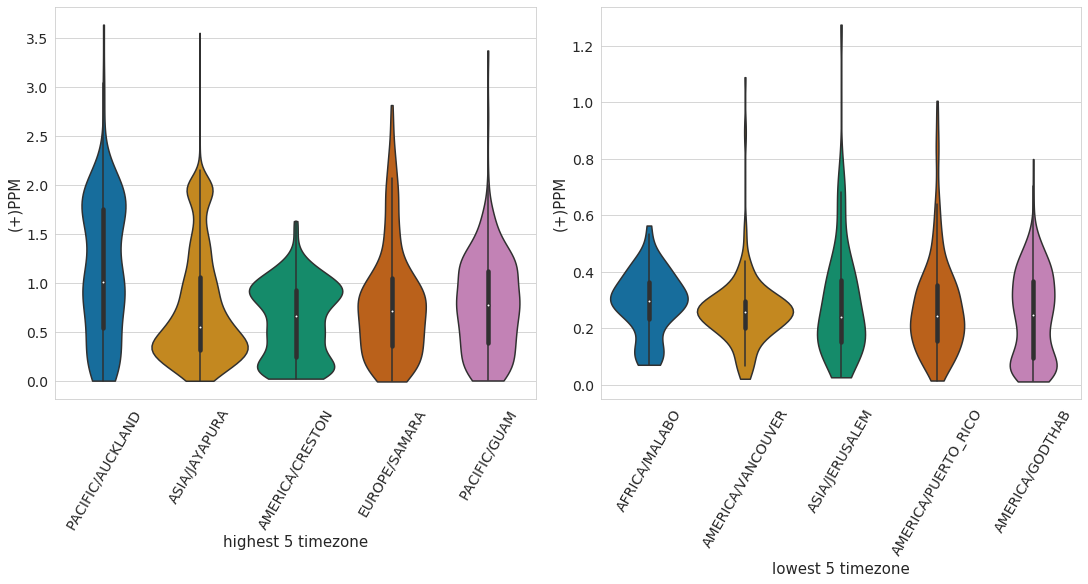

             timezone  direction  average_ppm       std  count
18   AFRICA/BUJUMBURA       -1.0     1.122752  1.025191     42
140  AMERICA/EDMONTON       -1.0     1.059950  0.758699    167
511  PACIFIC/AUCKLAND       -1.0     0.980501  0.833698     88
40      AFRICA/HARARE       -1.0     0.849392  0.782876    242
369      ASIA/YAKUTSK       -1.0     0.768867  0.585902     69
..                ...        ...          ...       ...    ...
383  ATLANTIC/MADEIRA       -1.0     0.161512  0.178383  22831
148   AMERICA/GODTHAB       -1.0     0.150319  0.136494    177
99   AMERICA/ATIKOKAN       -1.0     0.149793  0.194452     46
161   AMERICA/HALIFAX       -1.0     0.149119  0.154251     70
293        ASIA/KABUL       -1.0     0.128456  0.147637    358

[196 rows x 5 columns]


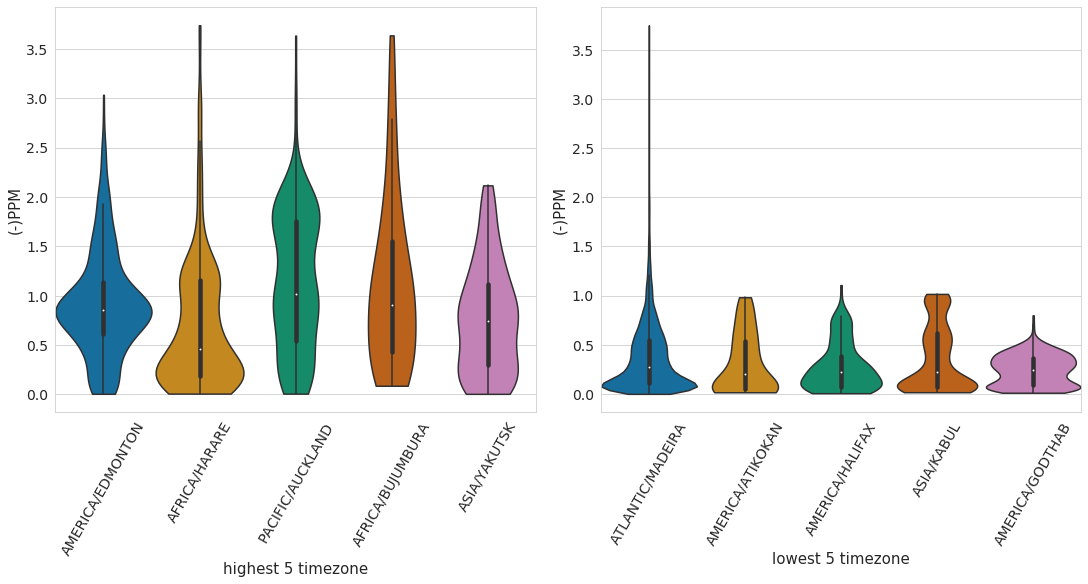

In [17]:
print(dfTimezoneGBPos);
boxPlotPPMTopBot(dfSamples_droppedDup,dfTimezoneGBPos,'ppm','timezone','(+)PPM','timezone')
print(dfTimezoneGBNeg);
boxPlotPPMTopBot(dfSamples_droppedDup,dfTimezoneGBNeg,'ppm','timezone','(-)PPM','timezone')

    country_code  direction  average_ppm       std  count
186           lr        1.0     0.894506  0.567958     50
192           lu        1.0     0.878437  0.353265    490
324           tt        1.0     0.836098  0.289859    271
1             ae        1.0     0.817392  0.532737   1305
202           md        1.0     0.814916  0.432004    198
..           ...        ...          ...       ...    ...
47            bw        1.0     0.390221  0.171157    174
352           zw        1.0     0.380130  0.333139     89
206           mg        1.0     0.368198  0.204675    418
117           gl        1.0     0.342113  0.104013    168
125           gq        1.0     0.315997  0.073883     32

[130 rows x 5 columns]


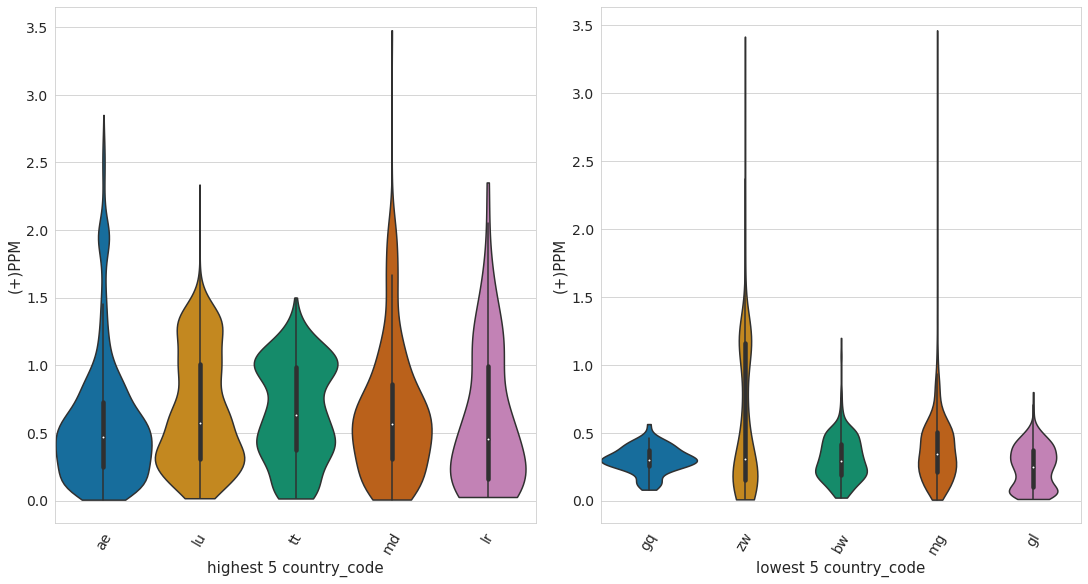

    country_code  direction  average_ppm       std  count
32            bi       -1.0     1.147976  1.024648     41
34            bj       -1.0     0.815978  0.902844     46
273           rs       -1.0     0.759188  0.508836    111
351           zw       -1.0     0.671655  0.597444    141
42            bs       -1.0     0.630038  0.550844    283
..           ...        ...          ...       ...    ...
263           pt       -1.0     0.172280  0.189092  49215
142           hu       -1.0     0.166200  0.163066    302
116           gl       -1.0     0.150717  0.138597    162
241           nl       -1.0     0.133984  0.138423    573
2             af       -1.0     0.131479  0.151704    333

[133 rows x 5 columns]


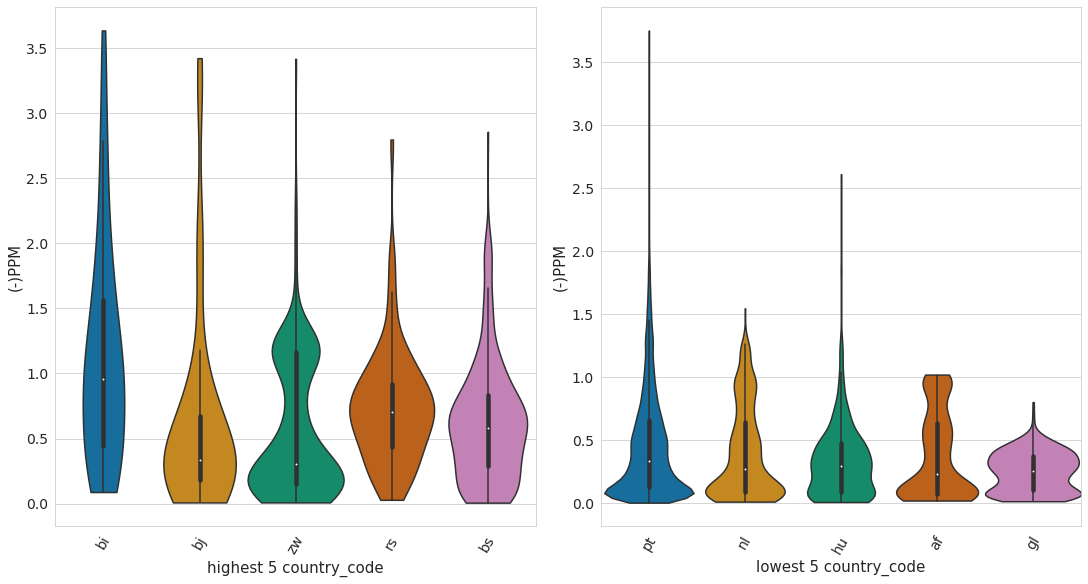

In [18]:
print(dfCountryGBPos);
boxPlotPPMTopBot(dfSamples_droppedDup,dfCountryGBPos,'ppm','country_code','(+)PPM','country_code')
print(dfCountryGBNeg);
boxPlotPPMTopBot(dfSamples_droppedDup,dfCountryGBNeg,'ppm','country_code','(-)PPM','country_code')

   screen_on  direction  average_ppm       std   count
1          0        1.0     0.634825  0.385644  245196
3          1        1.0     0.615828  0.386148  171014
   screen_on  direction  average_ppm       std   count
2          1       -1.0     0.348501  0.402825  271377
0          0       -1.0     0.254829  0.312842  200160


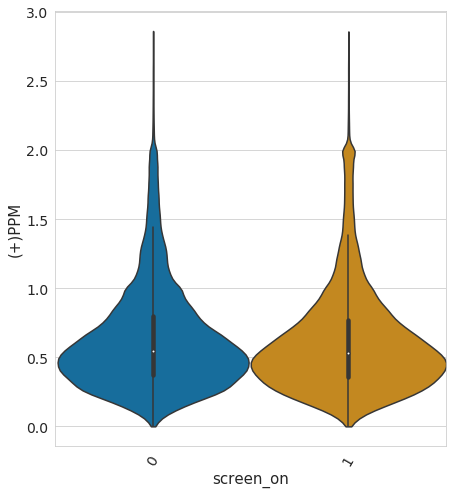

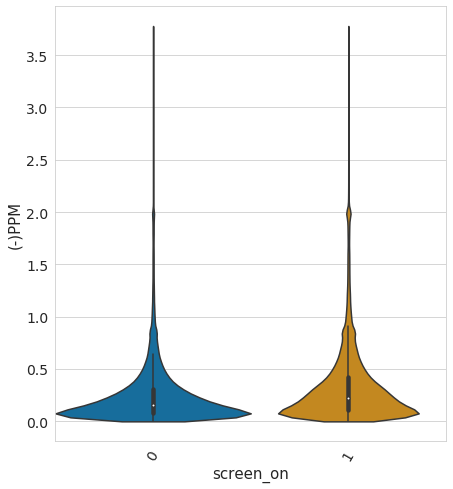

In [19]:
print(dfScreenGBPos);
boxPlotPPMAll(dfSamples_droppedDup_Screen.loc[(dfSamples_droppedDup_Screen['direction'] == 1)],'ppm','screen_on','(+)PPM','screen_on');
print(dfScreenGBNeg);
boxPlotPPMAll(dfSamples_droppedDup_Screen.loc[(dfSamples_droppedDup_Screen['direction'] == -1)],'ppm','screen_on','(-)PPM','screen_on');

   network_status  direction  average_ppm       std   count
27         EVDO_A        1.0     0.705090  0.294966     201
35          HSPAP        1.0     0.651794  0.434314   21027
41           UTMS        1.0     0.647940  0.402962    5957
31          HSDPA        1.0     0.646447  0.367209    1737
19   DISCONNECTED        1.0     0.627645  0.391134  119637
43           WIFI        1.0     0.621458  0.385341  144589
33           HSPA        1.0     0.619378  0.425604    9862
23           EDGE        1.0     0.596745  0.370583    3772
39            LTE        1.0     0.592249  0.346914   35494
1               0        1.0     0.572286  0.362194    3864
29           GPRS        1.0     0.569279  0.307469     410
37          HSUPA        1.0     0.548906  0.294746    1772
12          1XRTT        1.0     0.536932  0.244664      44
21  DISCONNECTING        1.0     0.515690  0.279942    1694
25          EHRPD        1.0     0.502450  0.214740      34
10             19        1.0     0.45639

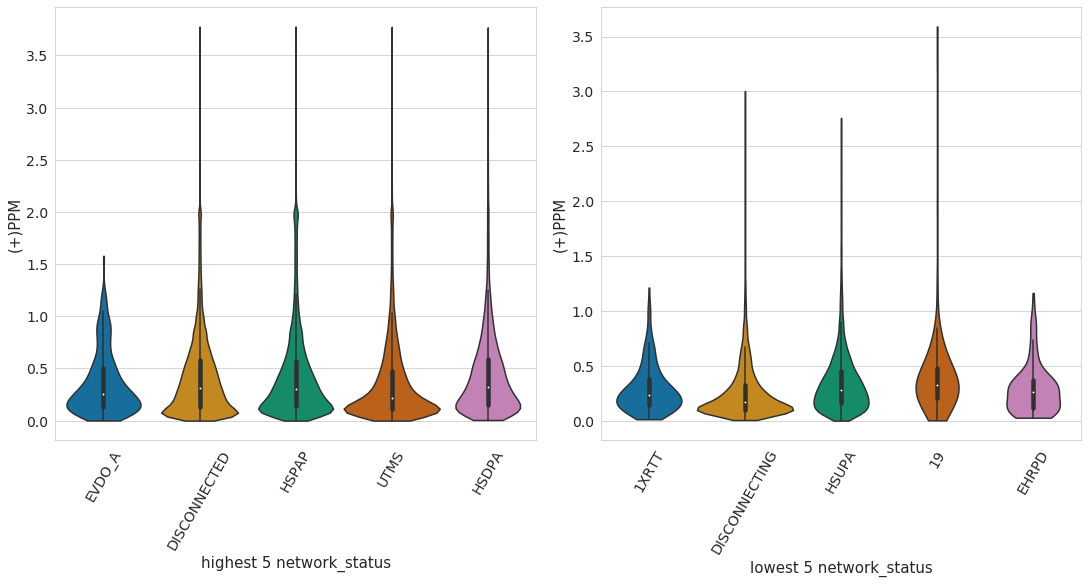

   network_status  direction  average_ppm       std   count
32           HSPA       -1.0     0.388189  0.434388   24311
9              19       -1.0     0.376588  0.504372     101
34          HSPAP       -1.0     0.360063  0.418261   54262
30          HSDPA       -1.0     0.344101  0.375872    4124
42           WIFI       -1.0     0.327699  0.391134  170261
0               0       -1.0     0.317924  0.338743    8333
28           GPRS       -1.0     0.297085  0.346119    1253
18   DISCONNECTED       -1.0     0.286122  0.354648  171335
16     CONNECTING       -1.0     0.276975  0.411505      84
22           EDGE       -1.0     0.272868  0.313876   11909
38            LTE       -1.0     0.263561  0.294194   57737
40           UTMS       -1.0     0.261075  0.335021   17187
36          HSUPA       -1.0     0.252374  0.227230    3594
11          1XRTT       -1.0     0.233495  0.163167     183
24          EHRPD       -1.0     0.231858  0.191790     120
26         EVDO_A       -1.0     0.22845

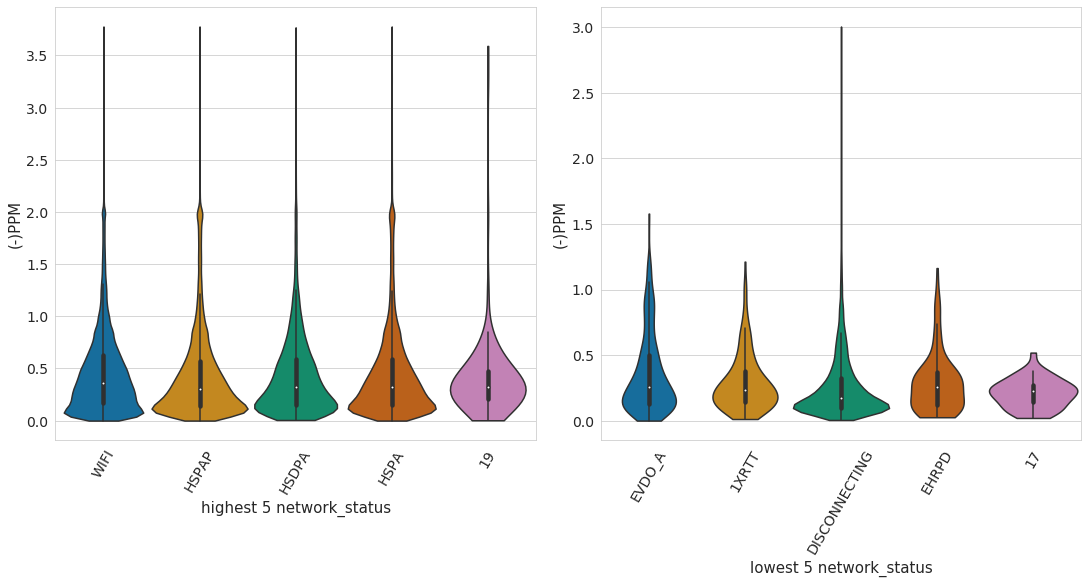

In [20]:
print(dfNetworkStatusGBPos);
boxPlotPPMTopBot(dfSamples_droppedDup_NetworkStatus,dfNetworkStatusGBPos,'ppm','network_status','(+)PPM','network_status')
print(dfNetworkStatusGBNeg);
boxPlotPPMTopBot(dfSamples_droppedDup_NetworkStatus,dfNetworkStatusGBNeg,'ppm','network_status','(-)PPM','network_status')